# Powerlifting

Study 1: Can I accurately predict a squat, bench, and deadlift max based off of input parameters?

Study 2: Which lift attempt tends to be the most successful?

Study 3: Can I accurately predict the future maxes of the average male/female achieved in each of the 3 lifts?

## Install modules

In [1]:
!pip install xgboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Create data

In [3]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Powerlifting/PowerliftingData.csv')

<ipython-input-3-82e6681e6515>:1: DtypeWarning: Columns (33,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Powerlifting/PowerliftingData.csv')


In [4]:
df_raw.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


In [5]:
df_raw.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,...,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift
count,2.000414e+06,3.036209e+06,927345.000000,918000.000000,893784.000000,8528.000000,2.058120e+06,1.416872e+06,1.401002e+06,1.357917e+06,...,1.045538e+06,1.027567e+06,986451.000000,23211.000000,2.232913e+06,2.871180e+06,2.846132e+06,2.846132e+06,2.846132e+06,2.593993e+06
mean,3.074627e+01,8.417016e+01,115.426239,99.874368,41.472546,77.224783,1.744330e+02,8.360096e+01,5.769170e+01,-1.447431e+01,...,1.598597e+02,1.343855e+02,24.385716,80.458670,1.901656e+02,3.786244e+02,2.757079e+02,2.746050e+02,2.587170e+02,6.461073e+01
std,1.321553e+01,2.261771e+01,135.993144,159.834226,189.983422,179.478007,6.827924e+01,9.754178e+01,1.222884e+02,1.382425e+02,...,1.071724e+02,1.545987e+02,210.711985,185.873632,6.199393e+01,2.054129e+02,1.290883e+02,1.285352e+02,1.221924e+02,1.627856e+01
min,0.000000e+00,1.000000e+01,-555.000000,-580.000000,-600.500000,-550.000000,-5.080200e+02,-6.355000e+02,-6.355000e+02,-5.750000e+02,...,-5.000000e+02,-5.025000e+02,-587.500000,-500.000000,-4.100000e+02,1.000000e+00,6.800000e-01,6.700000e-01,6.400000e-01,5.000000e-01
25%,2.050000e+01,6.720000e+01,90.000000,80.000000,-150.000000,-77.500000,1.225000e+02,5.750000e+01,1.811000e+01,-1.325000e+02,...,1.250000e+02,1.175000e+02,-200.000000,-77.750000,1.425000e+02,2.025000e+02,1.457700e+02,1.451500e+02,1.373500e+02,5.294000e+01
50%,2.700000e+01,8.194000e+01,145.000000,147.500000,117.500000,130.000000,1.700000e+02,1.025000e+02,9.500000e+01,-5.750000e+01,...,1.800000e+02,1.775000e+02,125.000000,143.000000,1.900000e+02,3.575000e+02,2.986400e+02,2.975800e+02,2.776500e+02,6.453000e+01
75%,3.850000e+01,9.878000e+01,197.500000,202.500000,192.500000,195.000000,2.177200e+02,1.400000e+02,1.400000e+02,1.156700e+02,...,2.225000e+02,2.300000e+02,207.000000,205.000000,2.350000e+02,5.350000e+02,3.732200e+02,3.715200e+02,3.517000e+02,7.591000e+01
max,9.800000e+01,3.000000e+02,555.000000,577.500000,595.000000,592.390000,5.950000e+02,5.510000e+02,5.216300e+02,6.355000e+02,...,4.500000e+02,4.675000e+02,487.500000,440.500000,4.875000e+02,1.407500e+03,7.991100e+02,7.933300e+02,7.569000e+02,1.761300e+02


In [6]:
df_raw.count()

Name                3074785
Sex                 3074785
Event               3074785
Equipment           3074785
Age                 2000414
AgeClass            2256759
BirthYearClass      2070054
Division            3073350
BodyweightKg        3036209
WeightClassKg       3033309
Squat1Kg             927345
Squat2Kg             918000
Squat3Kg             893784
Squat4Kg               8528
Best3SquatKg        2058120
Bench1Kg            1416872
Bench2Kg            1401002
Bench3Kg            1357917
Bench4Kg              21105
Best3BenchKg        2713726
Deadlift1Kg         1045538
Deadlift2Kg         1027567
Deadlift3Kg          986451
Deadlift4Kg           23211
Best3DeadliftKg     2232913
TotalKg             2871180
Place               3074785
Dots                2846132
Wilks               2846132
Glossbrenner        2846132
Goodlift            2593993
Tested              2264084
Country             1784252
State                651242
Federation          3074785
ParentFederation    

### Study 1

Can I accurately predict a squat, bench, and deadlift max based off of input parameters?

#### Data cleaning

Note: It appears Dots, Wilks, Glossbrenner, and Goodlift are all diferent powerlifting metrics. We will not include these.

In [7]:
# What is Tested?
df_raw.Tested.unique()

array(['Yes', nan], dtype=object)

Assuming the Tested column is whether or not the lifter has been tested for PEDs, which it appears everyone has. We will not include this.

In [8]:
# Let's look at the Equipment column
df_raw.Equipment.unique()

array(['Raw', 'Wraps', 'Multi-ply', 'Single-ply', 'Unlimited', 'Straps'],
      dtype=object)

Equipment most definitely is an interesting feature. May do an analysis with and without it.

In [9]:
# Create new working dataframe of only necessary columns, will delete more later
df = df_raw.loc[:, ['Sex', 'Equipment', 'Age', 'AgeClass', 'BodyweightKg', 'WeightClassKg',
                    'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Place']]

In [10]:
df.head()

,Sex,Equipment,Age,AgeClass,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place
0,F,Raw,33.0,24-34,58.30,60,80.0,60.0,107.5,247.5,1
1,F,Raw,43.0,40-44,73.10,75,105.0,67.5,110.0,282.5,1
2,M,Raw,15.5,16-17,67.40,75,100.0,62.5,105.0,267.5,1
3,M,Raw,35.0,35-39,66.65,75,137.5,122.5,170.0,430.0,1
4,M,Raw,26.5,24-34,72.45,75,90.0,50.0,125.0,265.0,1


In [11]:
df.describe()

,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg
count,2.000414e+06,3.036209e+06,2.058120e+06,2.713726e+06,2.232913e+06,2.871180e+06
mean,3.074627e+01,8.417016e+01,1.744330e+02,1.180459e+02,1.901656e+02,3.786244e+02
std,1.321553e+01,2.261771e+01,6.827924e+01,5.348888e+01,6.199393e+01,2.054129e+02
min,0.000000e+00,1.000000e+01,-5.080200e+02,-5.225000e+02,-4.100000e+02,1.000000e+00
25%,2.050000e+01,6.720000e+01,1.225000e+02,7.500000e+01,1.425000e+02,2.025000e+02
50%,2.700000e+01,8.194000e+01,1.700000e+02,1.150000e+02,1.900000e+02,3.575000e+02
75%,3.850000e+01,9.878000e+01,2.177200e+02,1.500000e+02,2.350000e+02,5.350000e+02
max,9.800000e+01,3.000000e+02,5.950000e+02,6.355000e+02,4.875000e+02,1.407500e+03


In [12]:
# Drop duplicates
df = df.drop_duplicates()

In [13]:
# Remove rows with null values in only certain columns
df = df[df['Sex'].notnull()]
df = df[df['Age'].notnull()]
df = df[df['Equipment'].notnull()]
df = df[df['BodyweightKg'].notnull()]
df = df[df['TotalKg'].notnull()]

In [14]:
df.isnull().sum()

Sex                     0
Equipment               0
Age                     0
AgeClass              308
BodyweightKg            0
WeightClassKg       17163
Best3SquatKg       659643
Best3BenchKg       148109
Best3DeadliftKg    499745
TotalKg                 0
Place                   0
dtype: int64

In [15]:
# Investigate Place column, I know for sure we will remove DQ and NS
df.Place.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', 'G',
       '12', '14', '15', '16', '17', '18', '19', '20', '21', '23', '24',
       '22', '34', '25', '31', '28', '33', '27', '35', '26', '36', '30',
       '32', '29', '39', '48', '52', '40', '43', '47', '50', '54', '64',
       '65', '67', '72', '76', '77', '83', '86', '90', '37', '41', '42',
       '51', '68', '46', '49', '38', '44', '45', '53', '55', '56', '57',
       '58', '59', '60', '61', '62', '63', '66', '69', '70', '71', '73',
       '74', '75', '78', '79', '80', '81', '82', '84', '85', '87', '88',
       '89', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '195'], dtype=object)

In [16]:
# Let's investigate G
df.loc[df.Place == 'G'].describe()

,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg
count,6853.000000,6853.000000,5194.000000,6547.000000,5483.000000,6853.000000
mean,28.892456,81.953131,173.182126,115.432927,191.595595,395.885405
std,12.886632,21.983428,69.206937,52.521625,65.459520,213.478520
min,5.000000,15.880000,11.340000,4.000000,16.000000,4.000000
25%,20.000000,66.660000,120.000000,75.000000,142.500000,215.000000
50%,25.500000,80.500000,170.000000,110.000000,192.500000,392.500000
75%,34.500000,93.400000,215.000000,147.500000,240.000000,555.000000
max,86.500000,230.000000,521.630000,455.000000,419.570000,1185.000000


In [17]:
# G seems okay, so we will remove DQ and NS
df = df.loc[df.Place != 'DQ']
df = df.loc[df.Place != 'NS']
df.Place.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', 'G',
       '12', '14', '15', '16', '17', '18', '19', '20', '21', '23', '24',
       '22', '34', '25', '31', '28', '33', '27', '35', '26', '36', '30',
       '32', '29', '39', '48', '52', '40', '43', '47', '50', '54', '64',
       '65', '67', '72', '76', '77', '83', '86', '90', '37', '41', '42',
       '51', '68', '46', '49', '38', '44', '45', '53', '55', '56', '57',
       '58', '59', '60', '61', '62', '63', '66', '69', '70', '71', '73',
       '74', '75', '78', '79', '80', '81', '82', '84', '85', '87', '88',
       '89', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '195'], dtype=object)

In [18]:
# Let's look at Sex
df.Sex.unique()

array(['F', 'M', 'Mx'], dtype=object)

In [19]:
# Check Sex frequency
df.Sex.value_counts()

Sex
M     1339475
F      468340
Mx         67
Name: count, dtype: int64

In [20]:
# Not enough Mx data to be valuable, let's remove
df = df.loc[df.Sex != 'Mx']

In [21]:
# Let's look at equipment
df.Equipment.unique()

array(['Raw', 'Wraps', 'Multi-ply', 'Single-ply', 'Unlimited', 'Straps'],
      dtype=object)

In [22]:
df.Equipment.value_counts()

Equipment
Raw           1088833
Single-ply     484726
Wraps          151169
Multi-ply       75759
Unlimited        7282
Straps             46
Name: count, dtype: int64

In [23]:
# Let's remove Straps, not enough instances
# Let's also make all values lowercase
df = df.loc[df['Equipment'] != 'Straps']
df['Equipment'] = df['Equipment'].str.lower()
df.head()

,Sex,Equipment,Age,AgeClass,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place
0,F,raw,33.0,24-34,58.30,60,80.0,60.0,107.5,247.5,1
1,F,raw,43.0,40-44,73.10,75,105.0,67.5,110.0,282.5,1
2,M,raw,15.5,16-17,67.40,75,100.0,62.5,105.0,267.5,1
3,M,raw,35.0,35-39,66.65,75,137.5,122.5,170.0,430.0,1
4,M,raw,26.5,24-34,72.45,75,90.0,50.0,125.0,265.0,1


In [24]:
# Don't need AgeClass or WeightClass since we are using Age and BodyWeight, let's remove
# Let's also remove Place
df = df.drop(['AgeClass', 'WeightClassKg', 'Place'], axis=1)
df.head()

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg
0,F,raw,33.0,58.30,80.0,60.0,107.5,247.5
1,F,raw,43.0,73.10,105.0,67.5,110.0,282.5
2,M,raw,15.5,67.40,100.0,62.5,105.0,267.5
3,M,raw,35.0,66.65,137.5,122.5,170.0,430.0
4,M,raw,26.5,72.45,90.0,50.0,125.0,265.0


In [25]:
# Let's look at age
df.Age.describe()

count    1.807769e+06
mean     3.059753e+01
std      1.321717e+01
min      0.000000e+00
25%      2.050000e+01
50%      2.700000e+01
75%      3.800000e+01
max      9.800000e+01
Name: Age, dtype: float64

In [26]:
df.loc[df['Age'] < 5].shape[0]

347

In [27]:
# We have 349 rows of data of competitors under the age of 5
# This isn't consistent with our age classes so we must remove them
df = df.loc[df['Age'] >= 5]

In [28]:
# Let's check bodyweight
df.BodyweightKg.describe()

count    1.807422e+06
mean     8.443551e+01
std      2.239746e+01
min      1.588000e+01
25%      6.750000e+01
50%      8.200000e+01
75%      9.850000e+01
max      3.000000e+02
Name: BodyweightKg, dtype: float64

16kg minimum bodyweight is reasonable, and so is a 300kg maximum (still scary)

No modifications will be made

In [ ]:
# Prepare new dataframes specific to each lift for analysis and modeling
df_squat = df.dropna(subset=['Best3SquatKg'])
df_squat['Best3SquatKg'] = df_squat['Best3SquatKg'].astype(int)

df_bench = df.dropna(subset=['Best3BenchKg'])
df_bench['Best3BenchKg'] = df_bench['Best3BenchKg'].astype(int)

df_deadlift = df.dropna(subset=['Best3DeadliftKg'])
df_deadlift['Best3DeadliftKg'] = df_deadlift['Best3DeadliftKg'].astype(int)

#### Data evaluation

In [ ]:
# Let's create samples for quicker visualization
dfs_squat = df_squat.sample(10000)
dfs_bench = df_bench.sample(10000)
dfs_deadlift = df_deadlift.sample(10000)

<Axes: xlabel='BodyweightKg', ylabel='Best3SquatKg'>

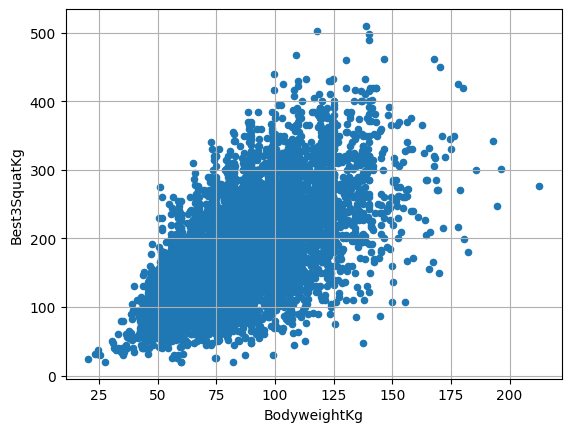

In [ ]:
dfs_squat.plot.scatter('BodyweightKg', # x-axis
                'Best3SquatKg', # y-axis
                grid=True, # Add a grid in the background
               )

<Axes: >

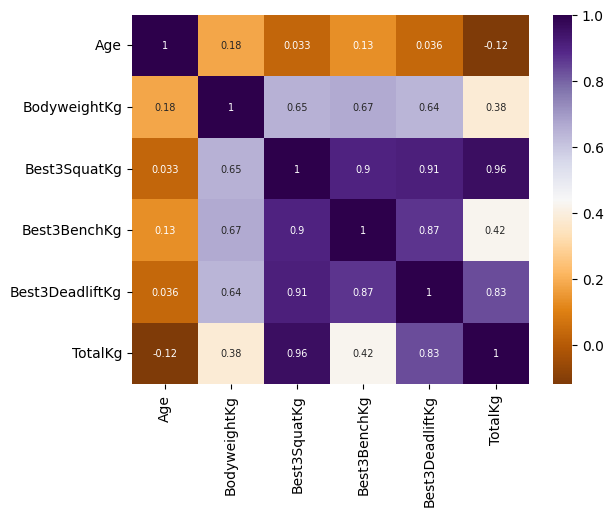

In [ ]:
# Heatmap
sns.heatmap(df.drop(columns=['Sex', 'Equipment', 'Place', 'AgeClass', 'WeightClassKg']).sample(10000).corr(), annot=True, annot_kws={"size": 7}, cmap='PuOr')

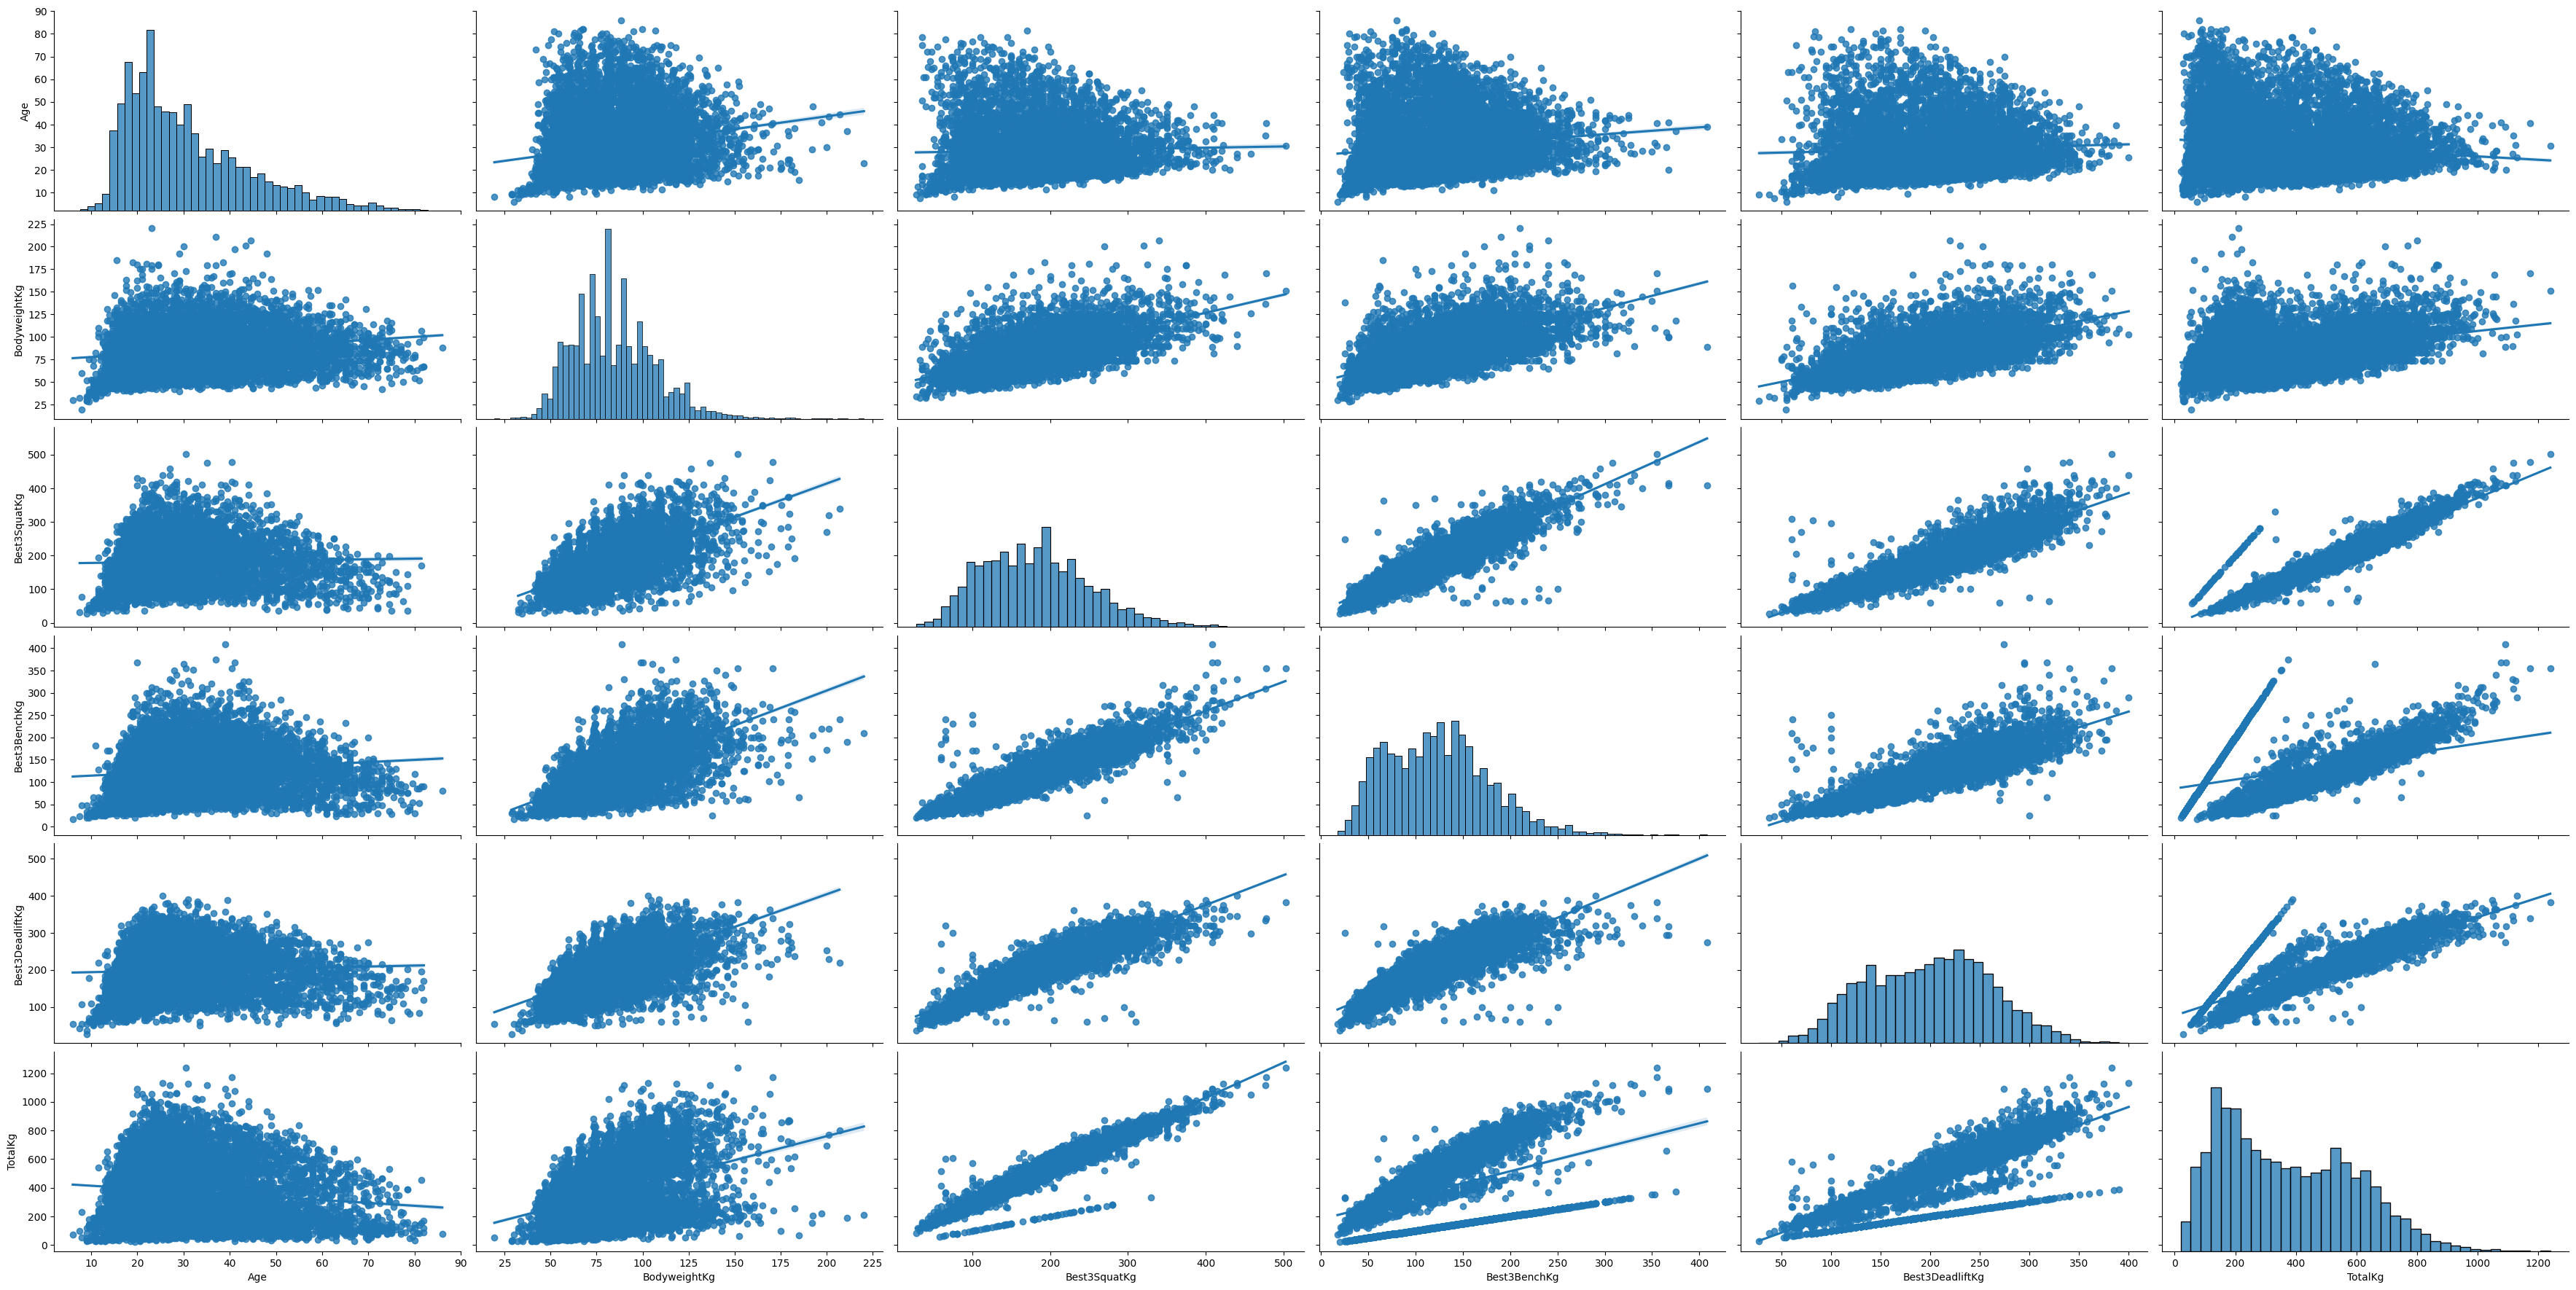

In [ ]:
# Pairplot
sns.pairplot(df.sample(10000), kind="reg", height=3, aspect=2)

<Axes: xlabel='Equipment', ylabel='Best3DeadliftKg'>

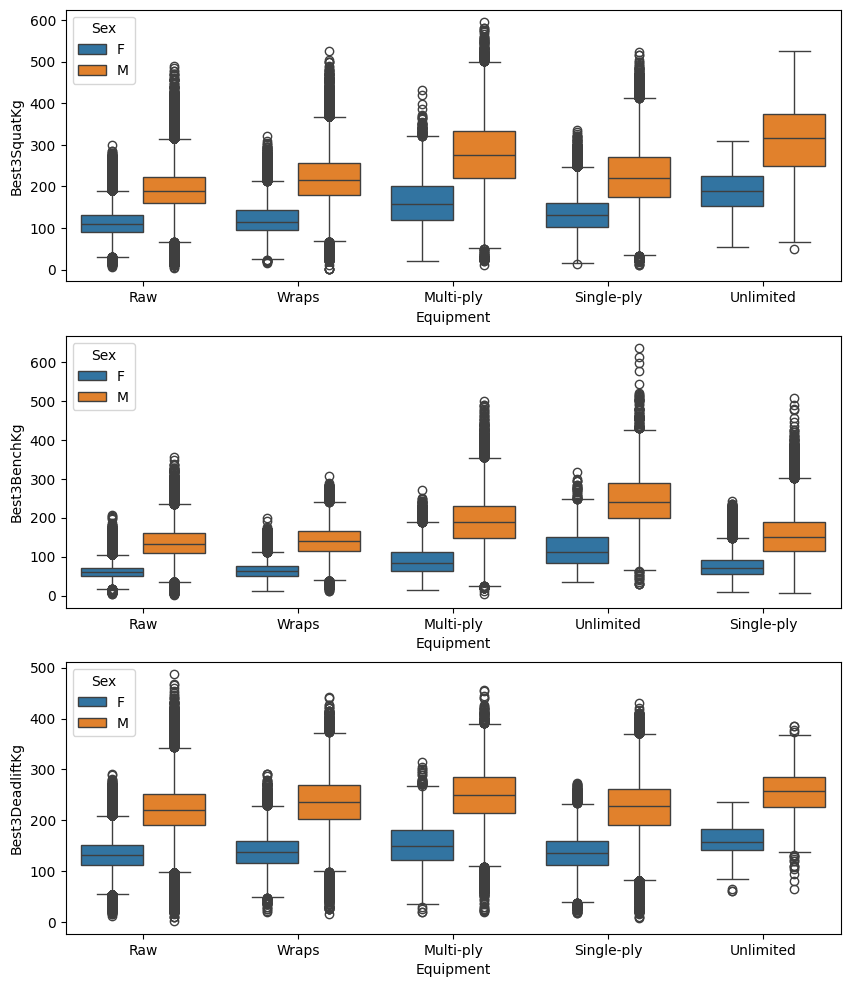

In [ ]:
# Let's check our work and visualize categorical outliers
fig, axes = plt.subplots(3,1,figsize=(10, 12))

sns.boxplot(x = "Equipment", y = "Best3SquatKg", hue = "Sex", data = df_squat, ax = axes[0])
sns.boxplot(x = "Equipment", y = "Best3BenchKg", hue = "Sex", data = df_bench, ax = axes[1])
sns.boxplot(x = "Equipment", y = "Best3DeadliftKg", hue = "Sex", data = df_deadlift, ax = axes[2])

#### Data preprocessing

In [30]:
df_squat.head()

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg
0,F,raw,33.0,58.30,80,60.0,107.5,247.5
1,F,raw,43.0,73.10,105,67.5,110.0,282.5
2,M,raw,15.5,67.40,100,62.5,105.0,267.5
3,M,raw,35.0,66.65,137,122.5,170.0,430.0
4,M,raw,26.5,72.45,90,50.0,125.0,265.0


In [31]:
# Create test/train split for each lift and store in array
# Access ref: final_data[x][y]
# x = [squat, bench, deadlift]
# y = [X_train, X_test, y_train, y_test]

num_features = ['Age', 'BodyweightKg']
cat_features = ['Sex', 'Equipment']
split_data = [train_test_split(df_squat[cat_features+num_features], df_squat['Best3SquatKg'], test_size=0.2, random_state=42),
              train_test_split(df_bench[cat_features+num_features], df_bench['Best3BenchKg'], test_size=0.2, random_state=42),
              train_test_split(df_deadlift[cat_features+num_features], df_deadlift['Best3DeadliftKg'], test_size=0.2, random_state=42)]

In [32]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ])

In [33]:
# Fit and transform the data and store in array
final = split_data.copy()

for i in range(len(final)):
  final[i][0] = preprocessor.fit_transform(split_data[i][0])
  final[i][1] = preprocessor.transform(split_data[i][1])

#### Model data

In [34]:
# Define dictionary containing preprocessed data
data = {
    'Squat': {
        'X_train': final[0][0],
        'X_test': final[0][1],
        'Y_train': final[0][2],
        'Y_test': final[0][3]
    },
    'Bench': {
        'X_train': final[1][0],
        'X_test': final[1][1],
        'Y_train': final[1][2],
        'Y_test': final[1][3]
    },
    'Deadlift': {
        'X_train': final[2][0],
        'X_test': final[2][1],
        'Y_train': final[2][2],
        'Y_test': final[2][3]
    }
}

In [35]:
# Define data pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor())
])

In [36]:
# Define the hyperparameter search space
param_space = {
    'regressor__n_estimators': np.arange(50, 200, 10),
    'regressor__max_depth': np.arange(1, 11),
    'regressor__learning_rate': np.logspace(-3, 0, 100)
}

In [37]:
# Hyperparameter optimization function

def optimize(pipeline, X_train, X_test, Y_train, Y_test):

  # Perform random search with RandomizedSearchCV
  random_search = RandomizedSearchCV(pipeline, param_distributions=param_space, n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='r2')
  random_search.fit(X_train, Y_train)

  # Get the best hyperparameters and corresponding results
  best_params = random_search.best_params_
  best_score = random_search.best_score_

  print("Best Hyperparameters:", best_params)
  print("Best Score:", best_score)

  # Evaluate the best model on the test set
  best_model = random_search.best_estimator_
  test_score = best_model.score(X_test, Y_test)
  print("Test Score:", test_score)

In [50]:
# Input custom data to predict
test_values = pd.DataFrame({
    'Sex': [str(input('Enter your gender (M or F): ')).upper()],
    'Age': [int(input('Enter your age: '))],
    'BodyweightKg': [int(float(input('Enter your weight in lbs: '))/2.205)],
    'Equipment': [str(input('Enter your equipment used (raw, single-ply, multi-ply, unlimited, or wraps): ')).lower()]
})

Enter your gender (M or F): f
Enter your age: 22
Enter your weight in lbs: 125
Enter your equipment used (raw, single-ply, multi-ply, unlimited, or wraps): raw


##### Squat

In [47]:
# Create new model
xgb_squat = pipeline.named_steps['regressor'].fit(data['Squat']['X_train'], data['Squat']['Y_train'])

In [48]:
# Calculate the R-squared score
r2_score(data['Squat']['Y_test'], xgb_squat.predict(data['Squat']['X_test']))

0.7054558292839507

In [ ]:
# Hyperparameter optimization
optimize(pipeline.named_steps['regressor'], data['Squat']['X_train'], data['Squat']['X_test'], data['Squat']['Y_train'], data['Squat']['Y_test'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:41:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'regressor__n_estimators': 150, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.02848035868435802}
Best Score: 0.7026305275596654
Test Score: 0.7054558292839507


In [51]:
# Make predictions on custom data
print('Your predicted squat max is: ' + str(xgb_squat.predict(preprocessor.transform(test_values))[0]*2.205) + ' lbs')

Your predicted squat max is: 231.46640613555908 lbs


##### Bench

In [53]:
# Create new model
xgb_bench = pipeline.named_steps['regressor'].fit(data['Bench']['X_train'], data['Bench']['Y_train'])

In [54]:
# Calculate the R-squared score
r2_score(data['Bench']['Y_test'], xgb_bench.predict(data['Bench']['X_test']))

0.7462422137879303

In [ ]:
# Hyperparameter optimization
optimize(pipeline.named_steps['regressor'], data['Bench']['X_train'], data['Bench']['X_test'], data['Bench']['Y_train'], data['Bench']['Y_test'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:07:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'regressor__n_estimators': 150, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.02848035868435802}
Best Score: 0.7472292461546234
Test Score: 0.7462422137879303


In [55]:
# Make predictions on custom data
print('Your predicted bench max is: ' + str(xgb_bench.predict(preprocessor.transform(test_values))[0]*2.205) + ' lbs')

Your predicted bench max is: 134.24204257965087 lbs


##### Deadlift

In [57]:
# Create new model
xgb_deadlift = pipeline.named_steps['regressor'].fit(data['Deadlift']['X_train'], data['Deadlift']['Y_train'])

In [58]:
# Calculate the R-squared score
r2_score(data['Deadlift']['Y_test'], xgb_deadlift.predict(data['Deadlift']['X_test']))

0.709506895001575

In [ ]:
# Hyperparameter optimization
optimize(pipeline.named_steps['regressor'], data['Deadlift']['X_train'], data['Deadlift']['X_test'], data['Deadlift']['Y_train'], data['Deadlift']['Y_test'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:09:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'regressor__n_estimators': 150, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.02848035868435802}
Best Score: 0.7103840588339161
Test Score: 0.709506895001575


In [59]:
# Make predictions on custom data
print('Your predicted deadlift max is: ' + str(xgb_deadlift.predict(preprocessor.transform(test_values))[0]*2.205) + ' lbs')

Your predicted deadlift max is: 282.9583005523682 lbs
